In [1]:
%load_ext autoreload
%autoreload 2

In [136]:
from fastai.vision.all import *
from utils import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm

from fastai.vision.learner import _resnet_split
import h5py

In [3]:
import debugpy
debugpy.listen(5678)

('127.0.0.1', 5678)

In [26]:
conf = {
    'bs':64,
    'arch':resnet34,
    'split':0
}

In [5]:
train_df = pd.read_csv(PATH/'train_split.csv')
train_df['is_valid'] = train_df.split==conf['split']

In [6]:
# def hash_label(x):
#     x = (13*x)%10000
#     return x // 2000
# train_df['split']=train_df.label_group.apply(hash_label)
# train_df.to_csv(PATH/'train_split.csv')

In [7]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 #splitter=RandomSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=ColReader('image', pref=PATH/'train_images'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'],num_workers=16)

In [9]:
def f1_score(pred_groups, real_groups):
    res =0
    for pred, real in zip(pred_groups, real_groups):
        inter = pred.intersection(real)
        res += 2 * len(inter) / (len(pred)+len(real))
    return res / len(pred_groups)

In [10]:
def groups(preds):
    groups = [set() for _ in range(len(preds))]
    matches = (preds[:,None]==preds[None,:]).cpu()
    xs, ys = torch.where(matches)
    for x,y in zip(xs,ys):
        groups[x].add(y.item())
    return groups
groups(torch.tensor([1,2,2,2,3,1]))

[{0, 5}, {1, 2, 3}, {1, 2, 3}, {1, 2, 3}, {4}, {0, 5}]

In [11]:
def groups_from_embs_chunked(embs, threshold):
    embs = F.normalize(embs)
    preds_groups = []
    for chunk_start in range(0, len(embs), 10000):
        chunk_end = min(chunk_start+10000, len(embs))
        sims = embs[chunk_start:chunk_end] @ embs.T
        for x in range(len(sims)):
            gr = torch.where(sims[x]>threshold)[0]
            preds_groups.append(gr.tolist())
    return preds_groups
        

In [12]:
def groups_from_embs(embs, threshold=0.9, sims=None):
    if sims is None: sims = emb_sim(embs)
    preds_groups=[]
    for x in range(len(embs)):
        gr = torch.where(sims[x]>threshold)[0]
        preds_groups.append(gr.tolist())
    return preds_groups


In [13]:


def cut_after_conv(model):
    model_stem =list(learn.model.children())[0].eval()
    pipeline = nn.Sequential(model_stem, AdaptiveConcatPool2d(), Flatten())
    return pipeline

def cut_after_first_lin(model):
    body, head = list(learn.model.children())
    pipeline = nn.Sequential(body,*list(head.children())[:5] )
    return pipeline

def cut_before_last_lin(model):
    body, head = list(learn.model.children())
    pipeline = nn.Sequential(body,*list(head.children())[:-1] )
    return pipeline

def embs_from_resnet(model, dl, cutter = cut_after_conv):
    model = cutter(model).eval()
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = model(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    return torch.cat(all_embs), torch.cat(all_ys)

In [14]:
def f1_from_preds(inp, tar):
    preds = inp.argmax(dim=1)
    pred_groups = groups(preds)
    real_groups = groups(tar)
    return f1_score(pred_groups, real_groups)

In [15]:
# Cosine similiarity across all pairs of rows
def emb_sim(inp):
    inp=F.normalize(inp)
    return inp @ inp.T

# F1 score of prediction groups based on target_groups
def score_groups(pred_matrix, target_matrix):
    intersect = pred_matrix.logical_and(target_matrix)
    f1s = 2 * intersect.sum(dim=1) / (target_matrix.sum(dim=1) + pred_matrix.sum(dim=1))
    return f1s.mean()

# Calculates score for all values of threshold with the given range and increment
def treshold_finder(embs, y, start=0.7, end=1):
    sims = emb_sim(embs)
    target_matrix = y[:,None]==y[None,:]
    scores, ts = [], np.linspace(start, end, num=100,endpoint=False)
    for t in ts:
        scores.append(score_groups(sims > t, target_matrix))
    best = np.array(scores).argmax()
    plt.title(f'Best is {scores[best]:.3f} at {ts[best]:.3f}')
    plt.plot(ts, scores)
    plt.show()
    print(scores[-1],ts[-1])
    return ts[best]

In [16]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm

In [17]:
def create_head(nf, n_out, mid_size=256):
    layers = [AdaptiveConcatPool2d(), Flatten()]
    layers += LinBnDrop(nf *2, mid_size, p=.26, act=nn.ReLU(inplace=True))
    #layers += LinBnDrop(nf *2, mid_size, p=.26)
    layers += LinBnDrop(mid_size, n_out, p=.5)
    return nn.Sequential(*layers)

def arcface_head(nf, n_out, mid_size=512):
    layers = list(create_head(nf, n_out, mid_size).children())
    layers[-1] = ArcFaceClassifier(mid_size, n_out)
    return nn.Sequential(*layers)

def arcface_loss(cosine, targ, m=.4, s=10):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = dls.c) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)

def new_model(head_func=arcface_head):
    body = create_body(conf['arch'], cut=-2)
    nf = num_features_model(nn.Sequential(*body.children()))
    #head = create_head(512, dls.c, mid_size=256)
    head = head_func(nf, dls.c, mid_size=512)
    return nn.Sequential(body, head)

In [27]:
learn = Learner(dls,new_model(),splitter=_resnet_split, loss_func=arcface_loss, metrics=[AccumMetric(f1_from_preds, flatten=False)])

In [19]:
#learn = Learner(dls,new_model(create_head),splitter=_resnet_split, metrics=[AccumMetric(f1_from_preds, flatten=False)])

In [20]:
learn.fine_tune(20,1e-2)

epoch,train_loss,valid_loss,f1_from_preds,time
0,11.652727,14.141993,0.217936,01:49


epoch,train_loss,valid_loss,f1_from_preds,time
0,11.005886,13.949179,0.214113,02:10
1,10.375914,14.133080,0.298440,02:10
2,10.007521,14.235909,0.372858,02:09
3,9.757854,14.184062,0.444615,02:09
4,9.582348,14.233770,0.445091,02:09
5,9.387630,14.089831,0.487240,02:09
6,9.132201,14.156325,0.498713,02:09
7,8.959558,14.202035,0.496108,02:10
8,8.742417,14.225010,0.522365,02:09
9,8.543839,14.170694,0.537099,02:09


In [28]:
learn.load('resnet34_arcface')

# VALIDATION Non arcface

In [75]:
embs, y = embs_from_resnet(learn.model.cuda(), dls.valid, cut_after_conv)


  0%|          | 0/38 [00:00<?, ?it/s]

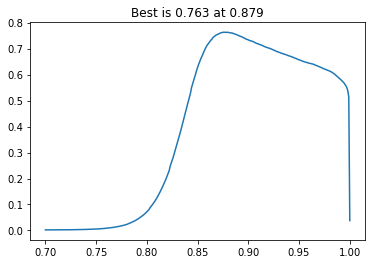

CPU times: user 890 ms, sys: 257 ms, total: 1.15 s
Wall time: 1.15 s


0.8790000000000001

In [76]:
%%time
treshold_finder(embs, y)

In [82]:
embs, y = embs_from_resnet(learn.model.cuda(), dls.valid, cut_after_first_lin)

  0%|          | 0/38 [00:00<?, ?it/s]

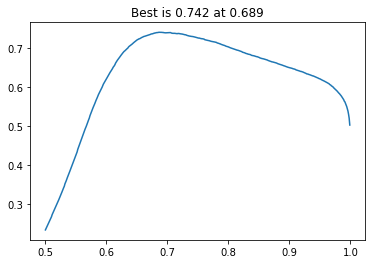

0.6890000000000002

In [83]:
treshold_finder(embs, y, start = .5)

In [ ]:
embs, y = embs_from_resnet(learn.model, dls.valid, cut_before_last_lin)


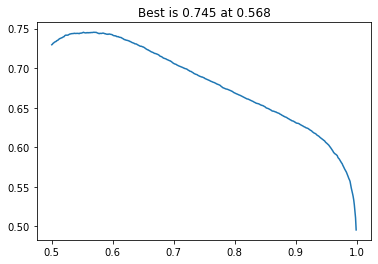

0.5680000000000001

In [81]:
treshold_finder(embs, y, start = .5)

# VALIDATION arcface

In [21]:
embs, y = embs_from_resnet(learn.model.cuda(), dls.valid, cut_after_conv)


  0%|          | 0/107 [00:00<?, ?it/s]

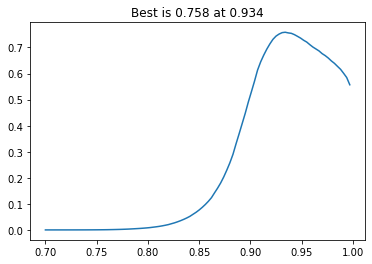

TensorCategory(0.5569, device='cuda:0') 0.997
CPU times: user 512 ms, sys: 12.6 ms, total: 524 ms
Wall time: 523 ms


0.9339999999999999

In [22]:
%%time
treshold_finder(embs, y)

In [23]:
embs, y = embs_from_resnet(learn.model.cuda(), dls.valid, cut_after_first_lin)

  0%|          | 0/107 [00:00<?, ?it/s]

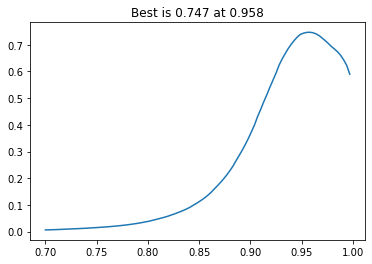

TensorCategory(0.5899, device='cuda:0') 0.997


0.958

In [24]:
treshold_finder(embs, y)

  0%|          | 0/107 [00:00<?, ?it/s]

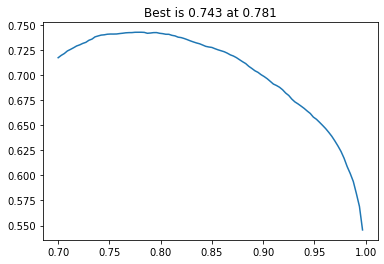

TensorCategory(0.5457, device='cuda:0') 0.997


0.7809999999999999

In [29]:
embs, y = embs_from_resnet(learn.model.cuda(), dls.valid, cut_before_last_lin)
treshold_finder(embs, y)

In [30]:
sims = emb_sim(embs)

In [105]:
vals, indices = sims.view(-1).topk(60000)

In [106]:
indices_x = indices // len(embs)
indices_y = indices % len(embs)

In [96]:
def f1(tp, fp, num_tar):
    return 2 * tp / (tp+fp+num_tar)

def build_from_pairs(xs, ys, target):
    score =0
    tp = torch.zeros_like(target)
    fp = torch.zeros_like(target)
    scores=[]
    group_sizes = (target[None,:]==target[:,None]).sum(dim=1)
    xs, ys, group_sizes, target, tp, fp = [x.tolist() for x in (xs, ys, group_sizes, target, tp, fp)]
    for i in range(len(xs)):
        x, y = xs[i], ys[i]
        group_size = group_sizes[x]
        score -= f1(tp[x], fp[x], group_size)
        if target[x]==target[y]: tp[x] +=1
        else: fp[x] +=1
        score += f1(tp[x], fp[x], group_size) 
        scores.append(score / len(target))
    plt.plot(scores)
    return scores

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 199 ms


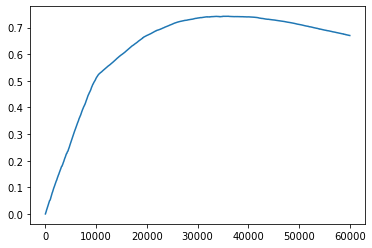

In [107]:
%%time
scores =build_from_pairs(indices_x, indices_y, y)

In [110]:
am =torch.tensor(scores).argmax()
print(f'{scores[am]:.3f} at {vals[am]:.3f} ({am} pairs)')

0.743 at 0.776 (35993 pairs)


In [111]:
am / len(y)

tensor(5.2869)

In [137]:
indices_x.shape

torch.Size([60000])

In [140]:
indices_x.cpu().numpy().shape

(60000,)

In [144]:
f = h5py.File("resnet_pairs.hdf5", "w")

f.create_dataset('indices_x', data =indices_x.cpu().numpy())
f.create_dataset('indices_y', data =indices_y.cpu().numpy())
f.create_dataset('values', data =vals.cpu().numpy())
f.close()

In [53]:
emb_groups = groups_from_embs_chunked(embs,.8)

In [54]:
valid_df = dls.valid.dataset.items

In [55]:
tmp = valid_df.groupby('label_group').posting_id.agg('unique').to_dict()
valid_df['target'] = valid_df.label_group.map(tmp)

<ipython-input-55-3b3ea5ea75a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['target'] = valid_df.label_group.map(tmp)


In [56]:
sum([len(g) for g in emb_groups])/ len(emb_groups)

4.839894242068155

In [57]:

matches = [valid_df.iloc[gr].posting_id.to_list() for gr in emb_groups]


In [58]:
valid_df['matches']= matches


<ipython-input-58-58d0e03a9928>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['matches']= matches


In [59]:
sum([len(a) for a in valid_df.target.to_list()]) / len(valid_df)

6.659811985898942

In [60]:
valid_df.to_csv('resnet_arcface_matches08.csv', index=False)

# Test 

In [21]:
fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title']]

In [22]:
fake_test_df = pd.concat([fake_test_df, fake_test_df])

In [23]:
fake_test_df.head()

,posting_id,image,image_phash,title
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml


In [24]:
test_dl = dls.test_dl(fake_test_df)

In [25]:
embs, _ = embs_from_resnet(learn.model.cuda(), test_dl, cut_before_last_lin)

  0%|          | 0/381 [00:00<?, ?it/s]

In [26]:
embs.shape

torch.Size([68500, 512])

In [27]:
del learn
torch.cuda.empty_cache()

In [35]:
%%time
emb_groups=groups_from_embs(embs, .779)

CPU times: user 6.72 s, sys: 33.9 ms, total: 6.76 s
Wall time: 6.75 s


In [36]:
%%time
emb_groups1 = groups_from_embs_chunked(embs,.778)


CPU times: user 6.63 s, sys: 35.2 ms, total: 6.66 s
Wall time: 6.66 s


In [29]:
def matches(group, data):
    postings = data.iloc[group].posting_id.tolist()
    return ' '.join(postings)

In [30]:
%%time
m = [matches(g, fake_test_df) for g in emb_groups]

CPU times: user 19.3 s, sys: 59.7 ms, total: 19.4 s
Wall time: 19.3 s


In [31]:
fake_test_df['matches']=m

In [32]:
fake_test_df.head()

,posting_id,image,image_phash,title,matches
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,train_129225211 train_2278313361 train_129225211 train_2278313361
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE",train_3386243561 train_1816968361 train_2120597446 train_3423213080 train_1831941588 train_3805508898 train_3386243561 train_1816968361 train_2120597446 train_3423213080 train_1831941588 train_3805508898
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,train_2288590299 train_3803689425 train_2043535264 train_2288590299 train_3803689425 train_2043535264
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi,train_2406599165 train_2088327894 train_3951567071 train_3576714541 train_2776897247 train_1991009626 train_3230106292 train_1061337929 train_1419795104 train_2805960789 train_3130811491 train_2472455109 train_3534777129 train_3758726710 train_1470643555 train_1647353375 train_1593362411 train_1331727138 train_2817956017 train_1762379453 train_3572158200 train_2560623727 train_1518005107 train_3526771004 train_2406599165 train_2088327894 train_3951567071 train_3576714541 train_2776897247 train_1991009626 train_3230106292 train_1061337929 train_1419795104 train_2805960789 train_3130811491 t...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,train_3369186413 train_921438619 train_3369186413 train_921438619


In [170]:
labs ='train_2406599165 train_2088327894 train_3951567071 train_3576714541 train_2776897247 train_1991009626 train_3230106292 train_1061337929 train_1419795104 train_2805960789 train_3130811491 train_2472455109 train_3534777129 train_3758726710 train_1470643555 train_1647353375 train_1593362411 train_1331727138 train_2817956017 train_1762379453 train_3572158200 train_2560623727 train_1518005107 train_3526771004 train_2406599165 train_2088327894 train_3951567071 train_3576714541 train_2776897247 train_1991009626 train_3230106292 train_1061337929 train_1419795104 train_2805960789 train_313081149'.split(' ')

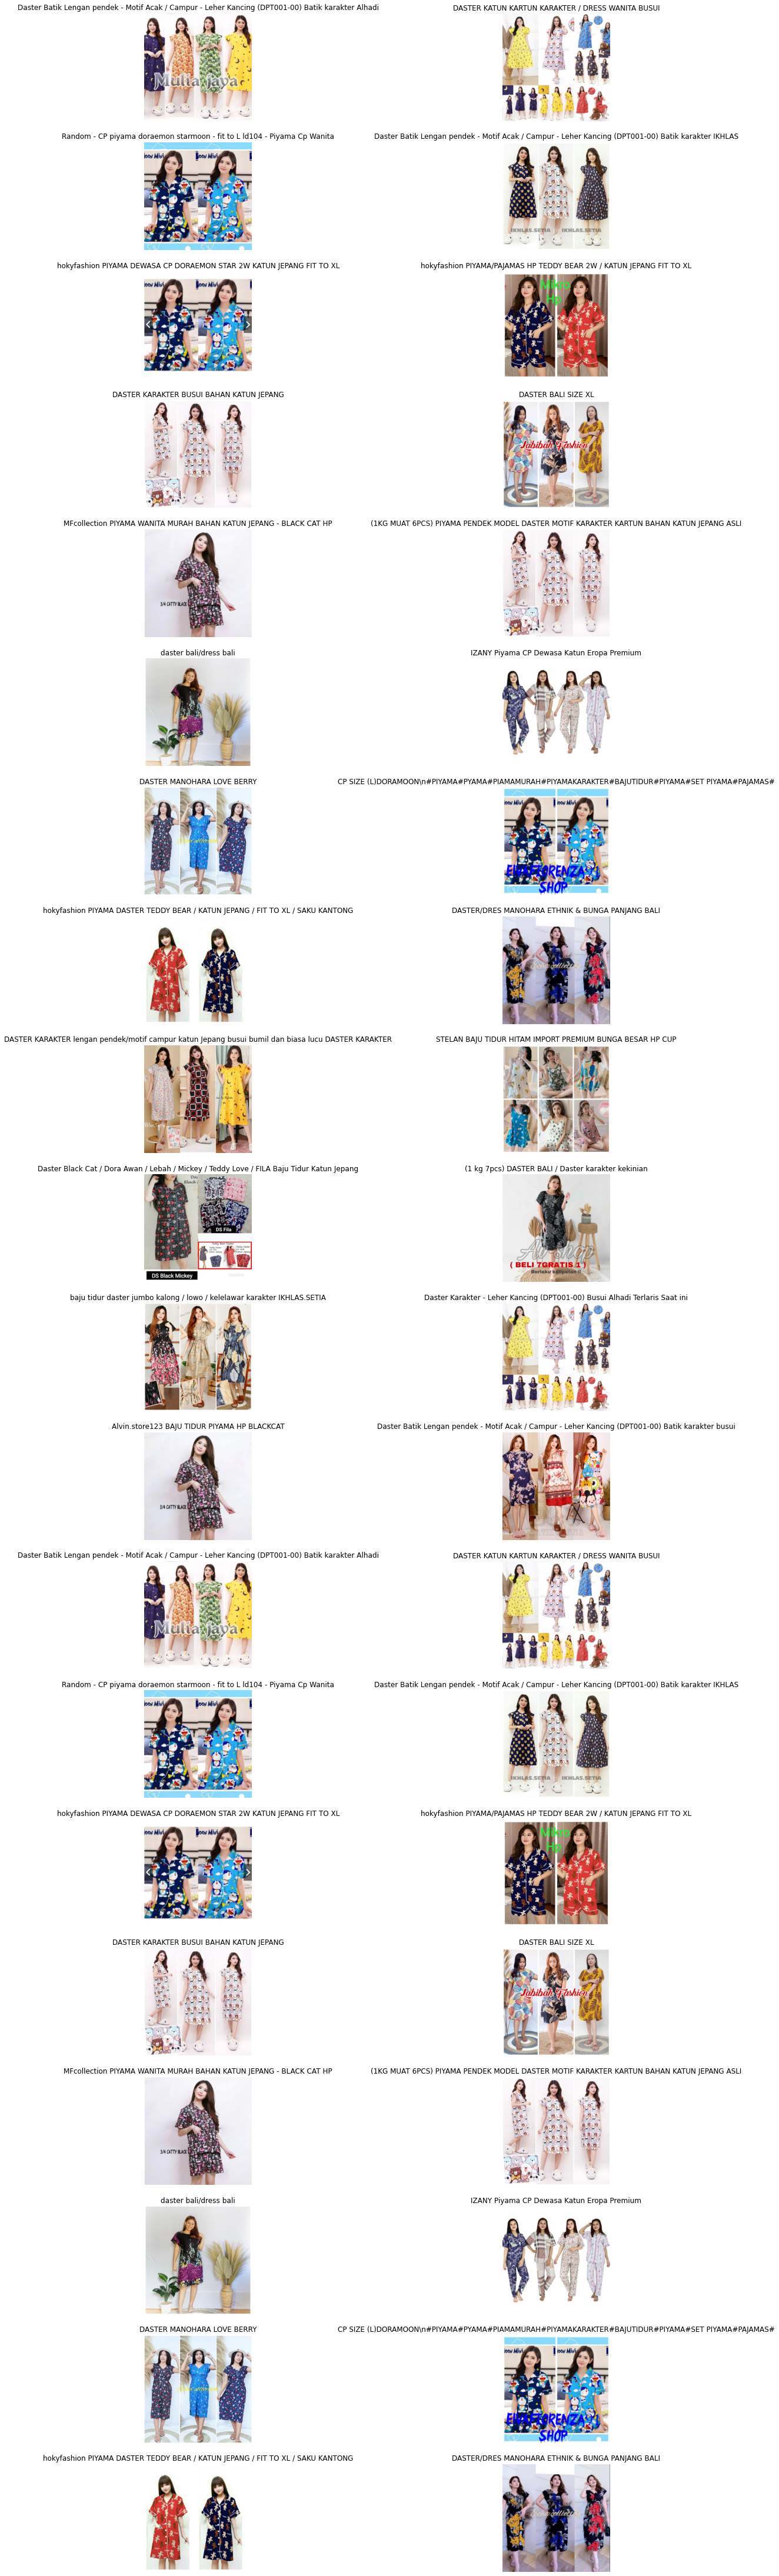

In [171]:
show(fake_test_df[fake_test_df.posting_id.isin(labs)])
